In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

In [2]:
NB_NODES = 50
DURATION = 10000
REVOLUTION = 1800
CONNECTION_RANGE = 30000

## 1. Importation des données

In [3]:
PATH = '..\..\data\cnes_swarm50\\track_'
satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df = pd.read_csv(PATH+str(i)+'.csv')
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)

satellites[0]

Extracting data: 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.428846e+05,-4.516533e+05,-4.604007e+05,-4.691266e+05,-4.778306e+05,-4.865122e+05,-4.951711e+05,-5.038068e+05,-5.124189e+05,-5.210071e+05,...,1.440812e+06,1.444147e+06,1.447475e+06,1.450795e+06,1.454108e+06,1.457413e+06,1.460711e+06,1.464001e+06,1.467284e+06,1.470559e+06
y,-7.388676e+05,-7.522884e+05,-7.656739e+05,-7.790237e+05,-7.923370e+05,-8.056132e+05,-8.188518e+05,-8.320520e+05,-8.452134e+05,-8.583352e+05,...,2.329204e+06,2.334225e+06,2.339233e+06,2.344229e+06,2.349213e+06,2.354185e+06,2.359145e+06,2.364092e+06,2.369028e+06,2.373951e+06
z,-2.011435e+06,-2.004528e+06,-1.997528e+06,-1.990435e+06,-1.983248e+06,-1.975968e+06,-1.968596e+06,-1.961132e+06,-1.953577e+06,-1.945930e+06,...,3.661057e+06,3.655167e+06,3.649258e+06,3.643331e+06,3.637384e+06,3.631419e+06,3.625435e+06,3.619433e+06,3.613412e+06,3.607372e+06


In [5]:
swarm_data = {}

with tqdm(total = 2*REVOLUTION, desc = 'Converting to Swarm') as pbar:
    for t in range(2*REVOLUTION):
        swarm_data[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████| 3600/3600 [00:11<00:00, 300.60it/s]

Swarm of 50 node(s), connection range: 30000


In [6]:
with tqdm(total=len(swarm_data.keys()), desc='Neighbor matrix') as pbar:
    for t in swarm_data.keys():
        neighbor_matrix = swarm_data[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix: 100%|██████████| 3600/3600 [00:06<00:00, 547.01it/s]


In [61]:
def plot_edges(swarm, n_color='blue', e_color='gray'):
    fig = plt.figure(figsize=(4,4))
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=50)
    for node in swarm.nodes:
        for n in node.neighbors:
            if n in swarm.nodes:
                ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], c=e_color)

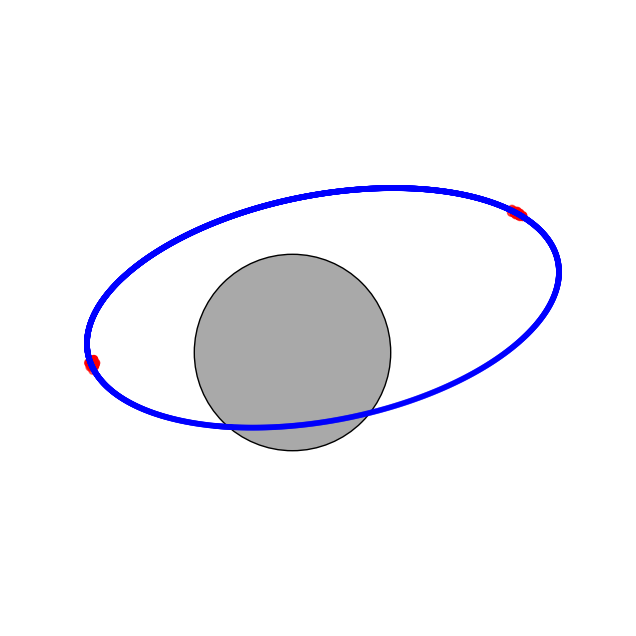

In [68]:
def plot_trajectory(nid, swarm_data, n_color='blue'):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [sw.nodes[nid].x for sw in swarm_data.values()]
    y_data = [sw.nodes[nid].y for sw in swarm_data.values()]
    z_data = [sw.nodes[nid].z for sw in swarm_data.values()]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=10)
    ax.scatter(0,0,0, c='darkgray', edgecolor='black', s=20000)
    for t in (200,1100):
        ax.scatter([node.x for node in swarm_data[t].nodes], 
                   [node.y for node in swarm_data[t].nodes], 
                   [node.z for node in swarm_data[t].nodes], 
                   c='red', 
                   s=30)
    
plot_trajectory(0, swarm_data)

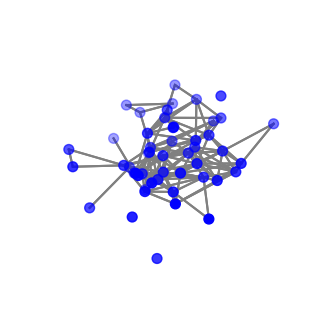

In [62]:
plot_edges(swarm_data[200])

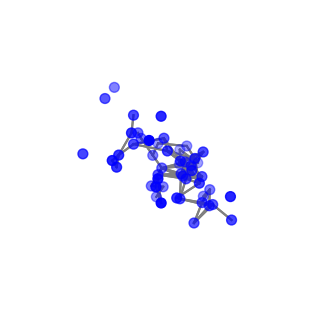

In [63]:
plot_edges(swarm_data[1100])